In [17]:

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image
from sklearn.decomposition import PCA
import glob
import string

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


1) We want to check if there are the same sample labels in the Noa file and the AdRp file.  Yes


# Looking at column counts

2) Let's consider the Noa files, stored in /n/regal/informatics/tsackton/damid/Ychrom/new_data/processed/20_bowtie2/NoA/bed_ext_counts .  We want to do column sums across all files: `for file in *; do awk '{s+=$4}END{print s}' $file; done`. 
The results are stored in `file_sums_Noa`.  

In [11]:
file_sums_NoA = pd.read_table("20160222_col_sums_NoA.txt", header=None)

In [27]:
print file_sums_NoA[0].min()
print file_sums_NoA[0].max()
print file_sums_NoA[0].mean()

170696
15988987
5441375.39815


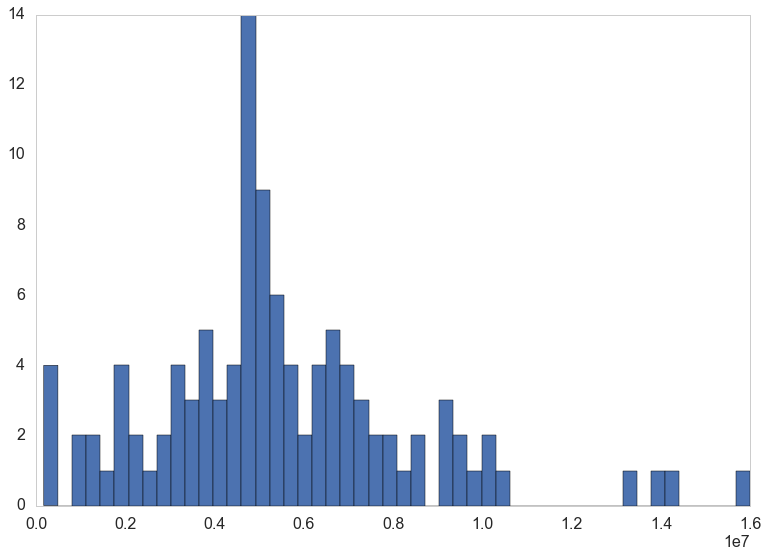

In [194]:
_=plt.hist(file_sums_NoA[0], bins=50)
plt.grid(False)

We find that the column counts vary very widely.  This raises two questions:
    1) do these column counts vary by tissue type/ country?
    2) do we see the same patterns in AdRp data?

To address the first point, we need the file names.  We get them by running `for file in *; do echo $file; done` in `/n/regal/informatics/tsackton/damid/Ychrom/new_data/processed/20_bowtie2/NoA/bed_ext_counts`

In [247]:
def split_names(row):
    labels=["RunProtein", "CountryLine", "TissueRep", "dataset", "notSure1", "notSure2"]
    d = {lab:ele for lab,ele in zip(labels, row.split("_"))}
    return d

def split_TissueRep(TissueRep):
    return {label:ele for label, ele in zip(["Tissue", "Rep"], TissueRep)}

def split_CountryLine(CL): 
    return {label:ele for label, ele in zip(["Country", "Line"], [CL[:2], CL[2:]])}

def separate_protein(RunProtein):
    return {label:ele for label, ele in zip(["NotSureProtein", "protein"], RunProtein.split("-"))}

file_names_NoA = pd.read_table("20160222_file_names_NoA.txt", header=None)

ind = [row.split("_cut")[0] for row in file_names_NoA[0].values]

file_names_NoA=pd.DataFrame([split_names(row) for row in file_names_NoA[0]])

file_names_NoA=pd.concat([file_names_NoA, pd.DataFrame([split_TissueRep(row) for row in file_names_NoA["TissueRep"]])], axis=1)
del file_names_NoA["TissueRep"]

file_names_NoA=pd.concat([file_names_NoA, pd.DataFrame([split_CountryLine(row) for row in file_names_NoA["CountryLine"]])], axis=1)
del file_names_NoA["CountryLine"]

file_names_NoA=pd.concat([file_names_NoA, pd.DataFrame([separate_protein(row) for row in file_names_NoA["RunProtein"]])], axis=1)
del file_names_NoA["RunProtein"]

file_names_NoA.index=ind

file_names_NoA.head()

,dataset,notSure1,notSure2,Rep,Tissue,Country,Line,NotSureProtein,protein
damID2-D1_Fr188_C1_NoA,NoA,cutadapt.ext,counts.bed,1,C,Fr,188,damID2,D1
damID2-D1_Fr188_C2_NoA,NoA,cutadapt.ext,counts.bed,2,C,Fr,188,damID2,D1
damID2-D1_Fr188_C3_NoA,NoA,cutadapt.ext,counts.bed,3,C,Fr,188,damID2,D1
damID2-D1_Fr188_T2_NoA,NoA,cutadapt.ext,counts.bed,2,T,Fr,188,damID2,D1
damID2-D1_Fr188_T3_NoA,NoA,cutadapt.ext,counts.bed,3,T,Fr,188,damID2,D1


(0, 12)

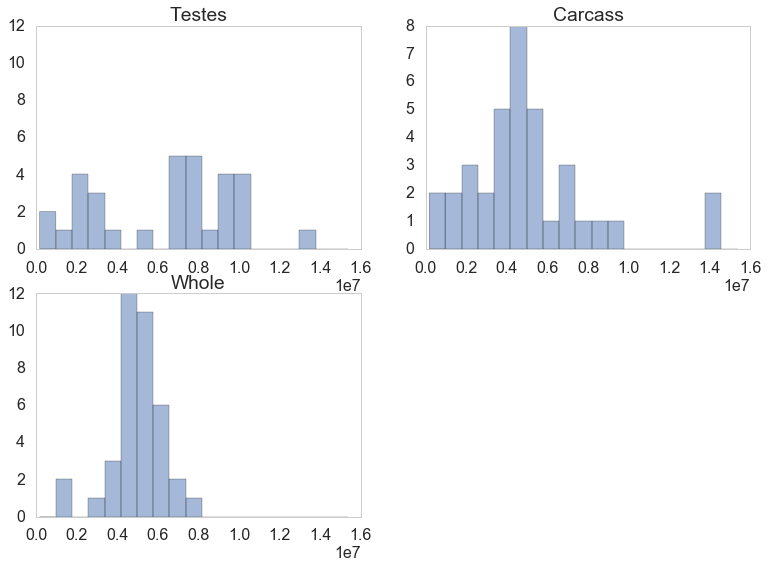

In [189]:
bins=range(170696,15988987,800000)

fig = plt.figure()
ax1 = fig.add_subplot(221)
_=ax1.hist(file_sums_NoA[file_names_NoA.Tissue=="T"][0].values,  alpha=.5, bins=bins)
ax1.set_title("Testes")
ax1.grid(b=False)
ax2.set_ylim([0,12])



ax2 = fig.add_subplot(222)
_=ax2.hist(file_sums_NoA[file_names_NoA.Tissue=="C"][0].values, alpha=.5, bins=bins)
ax2.set_title("Carcass")
ax2.grid(b=False)
ax1.set_ylim([0,12])

ax3 = fig.add_subplot(223)
_=ax3.hist(file_sums_NoA[file_names_NoA.Tissue=="w"][0].values, alpha=.5, bins=bins)
ax3.set_title("Whole")
ax3.grid(b=False)
ax3.set_ylim([0,12])


These histograms of column counts by tissue type all overlap, though "whole" has  amore restricted range.  We now look at the results by line.

(0, 6)

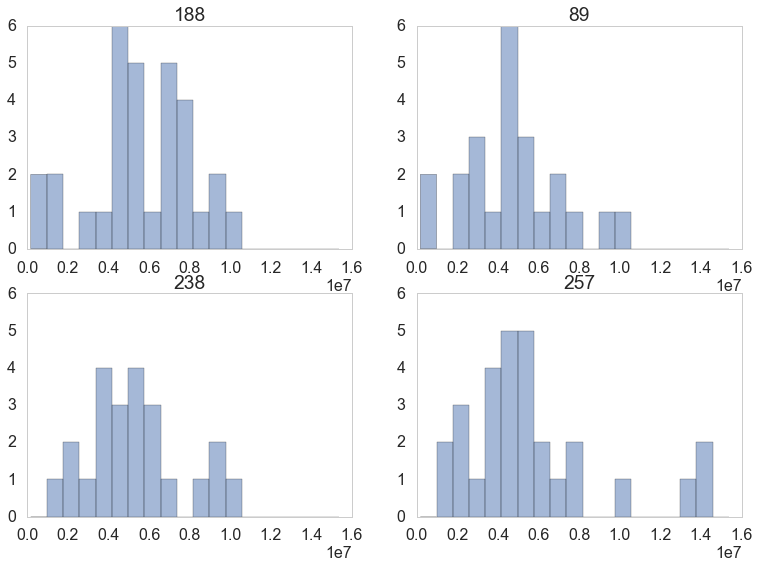

In [192]:
bins=range(170696,15988987,800000)

fig = plt.figure()
ax1 = fig.add_subplot(221)
_=ax1.hist(file_sums_NoA[file_names_NoA.Line=="188"][0].values,  alpha=.5, bins=bins)
ax1.set_title("188")
ax1.grid(b=False)
ax2.set_ylim([0,6])

ax2 = fig.add_subplot(222)
_=ax2.hist(file_sums_NoA[file_names_NoA.Line=="89"][0].values, alpha=.5, bins=bins)
ax2.set_title("89")
ax2.grid(b=False)
ax2.set_ylim([0,6])

ax3 = fig.add_subplot(223)
_=ax3.hist(file_sums_NoA[file_names_NoA.Line=="238"][0].values, alpha=.5, bins=bins)
ax3.set_title("238")
ax3.grid(b=False)
ax3.set_ylim([0,6])

ax4 = fig.add_subplot(224)
_=ax4.hist(file_sums_NoA[file_names_NoA.Line=="257"][0].values, alpha=.5, bins=bins)
ax4.set_title("257")
ax4.grid(b=False)
ax4.set_ylim([0,6])



Let's now identify files with particularly low column counts and particularly high column counts
- low counts: all France, mix of carcass and testes and different lines
- high counts: mostly zi 257, mix of carcass and testes

In [100]:
file_names_NoA[file_sums_NoA[0] <= 1000000]

,dataset,notSure1,notSure2,protein,Rep,Tissue,Country,Line
0,NoA,cutadapt.ext,counts.bed,damID2-D1,1,C,Fr,188
1,NoA,cutadapt.ext,counts.bed,damID2-D1,2,C,Fr,188
3,NoA,cutadapt.ext,counts.bed,damID2-D1,2,T,Fr,188
5,NoA,cutadapt.ext,counts.bed,damID2-D1,1,C,Fr,89
8,NoA,cutadapt.ext,counts.bed,damID2-D1,2,T,Fr,89


In [110]:
file_names_NoA[file_sums_NoA[0] >= 10300000]

,dataset,notSure1,notSure2,protein,Rep,Tissue,Country,Line
69,NoA,cutadapt.ext,counts.bed,damID3-Lam,1,T,Fr,188
102,NoA,cutadapt.ext,counts.bed,damID-Lam,1,C,Zi,257
103,NoA,cutadapt.ext,counts.bed,damID-Lam,2,C,Zi,257
104,NoA,cutadapt.ext,counts.bed,damID-Lam,3,C,Zi,257
107,NoA,cutadapt.ext,counts.bed,damID-Lam,3,T,Zi,257


# Correlating NoA and AdRp counts

We run the following, located in `/n/home08/leking/20151019Sackton/BAM_analysis` to get the correlations

import numpy as np
import pandas as pd
import glob

path="/n/regal/informatics/tsackton/damid/Ychrom/new_data/processed/20_bowtie2"
subpath_AdRp="/AdRp/bed_ext_counts/"
subpath_NoA="/NoA/bed_ext_counts/"

for file1, file2 in zip(sorted(glob.glob(path+subpath_NoA+"*")), sorted(glob.glob(path+subpath_AdRp+"*"))):
        f1 = pd.read_table(file1, header=None)
        f2 = pd.read_table(file2, header=None)
        print file1.split("/")[-1], file2.split("/")[-1]
        print np.corrcoef(f1[3], f2[3])[0,1]
        
        


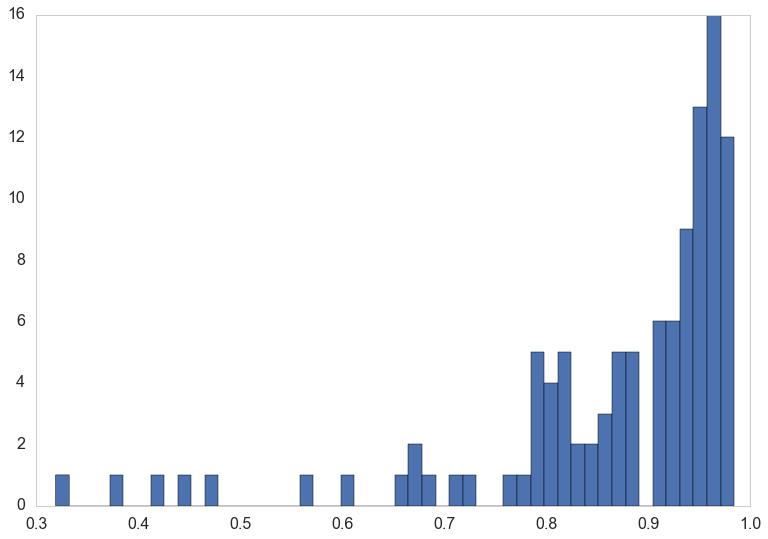

In [193]:
correls_NoA_AdRp = pd.read_table("20160222_NoA_AdRp_Correls.txt", header=None)
_=plt.hist(correls_NoA_AdRp[0], bins=50)
plt.grid(False)

You also get quite the range of correlations, though most are high (88 out of 108 are above .8)

In [119]:
print len(file_names_NoA[correls_NoA_AdRp[0]<.8])
print len(file_names_NoA[correls_NoA_AdRp[0]>=.8])

20
88


In [116]:
file_names_NoA[correls_NoA_AdRp[0]<.7]

,dataset,notSure1,notSure2,protein,Rep,Tissue,Country,Line
6,NoA,cutadapt.ext,counts.bed,damID2-D1,2,C,Fr,89
11,NoA,cutadapt.ext,counts.bed,damID2-D1,2,C,Zi,238
12,NoA,cutadapt.ext,counts.bed,damID2-D1,3,C,Zi,238
16,NoA,cutadapt.ext,counts.bed,damID2-D1,2,C,Zi,257
23,NoA,cutadapt.ext,counts.bed,damID2-Dam,3,C,Fr,89
26,NoA,cutadapt.ext,counts.bed,damID2-Dam,3,T,Fr,89
28,NoA,cutadapt.ext,counts.bed,damID2-Dam,2,C,Zi,238
31,NoA,cutadapt.ext,counts.bed,damID2-Lam,1,C,Fr,89
43,NoA,cutadapt.ext,counts.bed,damID3-D1,3,w,Fr,89
44,NoA,cutadapt.ext,counts.bed,damID3-D1,NaN,T,Zi,238


Seems to be a mixed bag of carcass, testes, whole genome, Fr, Zi, and line.

# figure out percentage of aligned reads that overlap a GATC site


in metrics file: 6th column of 2nd non blank, non commented row: numerator

in bed file: column sums: denominator

we expect most samples to be reasonably similar

but actually instead of doing this, i took the 7th column, whose title was pct_pf_reads_aligned. below is a plot.  Most values are high, but it is quite left skewed.

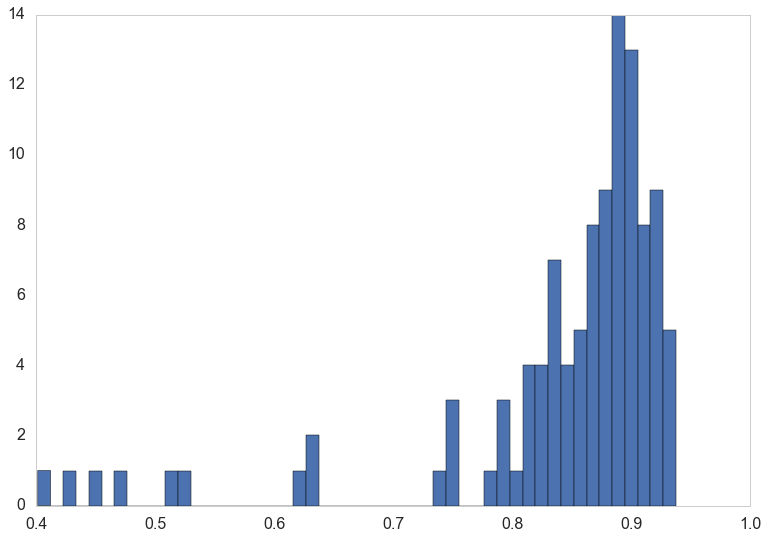

In [195]:
PCT_PF_reads_aligned_NoA = pd.read_table("20160223_PCT_PF_reads_aligned_NoA.txt", header=None)
_=plt.hist(PCT_PF_reads_aligned_NoA[0], bins=50)
plt.grid(False)

# Doing a PCA of NoA

In [134]:
files_dict={}
files_dict2={}

for fl in glob.glob("../20160223_BamData/*"):
    a= (fl.split('/')[-1]).split('_cut')[0]
    if a:
        files_dict[a]=pd.read_csv(fl, sep="\t", header=None)[3]

LoadedData=pd.DataFrame(files_dict)



,damID-Dam_Fr188_C1_NoA,damID-Dam_Fr188_C2_NoA,damID-Dam_Fr188_C3_NoA,damID-Dam_Fr188_C4_NoA,damID-Dam_Fr188_T3_NoA,damID-Dam_Fr188_T4_NoA,damID-Dam_Zi257_C1_NoA,damID-Dam_Zi257_C2_NoA,damID-Dam_Zi257_C3_NoA,damID-Dam_Zi257_W_NoA,damID-Dam_Zi275_T1_NoA,damID-Lam_Fr188_C1_NoA,damID-Lam_Fr188_C2_NoA,damID-Lam_Fr188_C3_NoA,damID-Lam_Fr188_C_NoA,damID-Lam_Fr188_T2_NoA,damID-Lam_Fr188_T3_NoA,damID-Lam_Zi257_C1_NoA,damID-Lam_Zi257_C2_NoA,damID-Lam_Zi257_C3_NoA,damID-Lam_Zi257_T1_NoA,damID-Lam_Zi257_T2_NoA,damID-Lam_Zi257_T3_NoA,damID2-D1_Fr188_C1_NoA,damID2-D1_Fr188_C2_NoA,damID2-D1_Fr188_C3_NoA,damID2-D1_Fr188_T2_NoA,damID2-D1_Fr188_T3_NoA,damID2-D1_Fr89_C1_NoA,damID2-D1_Fr89_C2_NoA,damID2-D1_Fr89_C3_NoA,damID2-D1_Fr89_T2_NoA,damID2-D1_Fr89_T3_NoA,damID2-D1_Zi238_C1_NoA,damID2-D1_Zi238_C2_NoA,damID2-D1_Zi238_C3_NoA,damID2-D1_Zi238_T2_NoA,damID2-D1_Zi238_T3_NoA,damID2-D1_Zi257_C1_NoA,damID2-D1_Zi257_C2_NoA,damID2-D1_Zi257_C3_NoA,damID2-D1_Zi257_T1_NoA,damID2-D1_Zi257_T2_NoA,damID2-D1_Zi257_T3_NoA,damID2-Dam_Fr188_w_NoA,damID2-Dam_Fr89_C1_NoA,damID2-Dam_Fr89_C3_NoA,damID2-Dam_Fr89_T1_NoA,damID2-Dam_Fr89_T2_NoA,damID2-Dam_Fr89_T3_NoA,...,damID2-Lam_Zi238_C3_NoA,damID2-Lam_Zi257_C4_NoA,damID3-D1_Fr188_T_NoA,damID3-D1_Fr188_w1_NoA,damID3-D1_Fr188_w2_NoA,damID3-D1_Fr188_w3_NoA,damID3-D1_Fr89_w1_NoA,damID3-D1_Fr89_w2_NoA,damID3-D1_Fr89_w3_NoA,damID3-D1_Zi238_T_NoA,damID3-D1_Zi238_w1_NoA,damID3-D1_Zi238_w2_NoA,damID3-D1_Zi238_w3_NoA,damID3-D1_Zi257_T_NoA,damID3-D1_Zi257_w1_NoA,damID3-D1_Zi257_w2_NoA,damID3-D1_Zi257_w3_NoA,damID3-Dam_Fr188_T2_NoA,damID3-Dam_Fr188_w1_NoA,damID3-Dam_Fr188_w2_NoA,damID3-Dam_Fr188_w3_NoA,damID3-Dam_Fr89_w1_NoA,damID3-Dam_Fr89_w2_NoA,damID3-Dam_Fr89_w3_NoA,damID3-Dam_Zi238_T1_NoA,damID3-Dam_Zi238_T2_NoA,damID3-Dam_Zi238_w1_NoA,damID3-Dam_Zi238_w2_NoA,damID3-Dam_Zi238_w3_NoA,damID3-Dam_Zi257_T1_NoA,damID3-Dam_Zi257_T2_NoA,damID3-Dam_Zi257_w1_NoA,damID3-Dam_Zi257_w2_NoA,damID3-Dam_Zi257_w3_NoA,damID3-Lam_Fr188_T1_NoA,damID3-Lam_Fr188_T4_NoA,damID3-Lam_Fr188_w1_NoA,damID3-Lam_Fr188_w2_NoA,damID3-Lam_Fr188_w3_NoA,damID3-Lam_Fr89_T1_NoA,damID3-Lam_Fr89_T2_NoA,damID3-Lam_Fr89_w1_NoA,damID3-Lam_Fr89_w2_NoA,damID3-Lam_Fr89_w3_NoA,damID3-Lam_Zi238_w1_NoA,damID3-Lam_Zi238_w2_NoA,damID3-Lam_Zi238_w3_NoA,damID3-Lam_Zi257_w1_NoA,damID3-Lam_Zi257_w2_NoA,damID3-Lam_Zi257_w3_NoA
0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0,1,1,0,0,1,0,0,1,1,0,1,1,1,0,0,3,1,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,1,1,0,0,1,0,0,1,1,0,1,1,1,0,0,3,1,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0
3,0,4,3,0,1,0,1,0,0,0,0,1,0,4,1,3,0,1,2,1,1,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,0,0,...,1,0,1,2,0,1,2,2,1,0,1,0,0,0,1,0,3,1,0,1,3,0,1,1,0,0,0,0,0,0,0,1,1,0,2,2,1,4,0,1,0,4,7,3,2,3,0,4,0,3
4,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1


We normalize the column values by column sums.

In [140]:
LoadedData2=LoadedData.div(LoadedData.sum(axis=0), axis=1)
LoadedData2.head()

,damID-Dam_Fr188_C1_NoA,damID-Dam_Fr188_C2_NoA,damID-Dam_Fr188_C3_NoA,damID-Dam_Fr188_C4_NoA,damID-Dam_Fr188_T3_NoA,damID-Dam_Fr188_T4_NoA,damID-Dam_Zi257_C1_NoA,damID-Dam_Zi257_C2_NoA,damID-Dam_Zi257_C3_NoA,damID-Dam_Zi257_W_NoA,damID-Dam_Zi275_T1_NoA,damID-Lam_Fr188_C1_NoA,damID-Lam_Fr188_C2_NoA,damID-Lam_Fr188_C3_NoA,damID-Lam_Fr188_C_NoA,damID-Lam_Fr188_T2_NoA,damID-Lam_Fr188_T3_NoA,damID-Lam_Zi257_C1_NoA,damID-Lam_Zi257_C2_NoA,damID-Lam_Zi257_C3_NoA,damID-Lam_Zi257_T1_NoA,damID-Lam_Zi257_T2_NoA,damID-Lam_Zi257_T3_NoA,damID2-D1_Fr188_C1_NoA,damID2-D1_Fr188_C2_NoA,damID2-D1_Fr188_C3_NoA,damID2-D1_Fr188_T2_NoA,damID2-D1_Fr188_T3_NoA,damID2-D1_Fr89_C1_NoA,damID2-D1_Fr89_C2_NoA,damID2-D1_Fr89_C3_NoA,damID2-D1_Fr89_T2_NoA,damID2-D1_Fr89_T3_NoA,damID2-D1_Zi238_C1_NoA,damID2-D1_Zi238_C2_NoA,damID2-D1_Zi238_C3_NoA,damID2-D1_Zi238_T2_NoA,damID2-D1_Zi238_T3_NoA,damID2-D1_Zi257_C1_NoA,damID2-D1_Zi257_C2_NoA,damID2-D1_Zi257_C3_NoA,damID2-D1_Zi257_T1_NoA,damID2-D1_Zi257_T2_NoA,damID2-D1_Zi257_T3_NoA,damID2-Dam_Fr188_w_NoA,damID2-Dam_Fr89_C1_NoA,damID2-Dam_Fr89_C3_NoA,damID2-Dam_Fr89_T1_NoA,damID2-Dam_Fr89_T2_NoA,damID2-Dam_Fr89_T3_NoA,...,damID2-Lam_Zi238_C3_NoA,damID2-Lam_Zi257_C4_NoA,damID3-D1_Fr188_T_NoA,damID3-D1_Fr188_w1_NoA,damID3-D1_Fr188_w2_NoA,damID3-D1_Fr188_w3_NoA,damID3-D1_Fr89_w1_NoA,damID3-D1_Fr89_w2_NoA,damID3-D1_Fr89_w3_NoA,damID3-D1_Zi238_T_NoA,damID3-D1_Zi238_w1_NoA,damID3-D1_Zi238_w2_NoA,damID3-D1_Zi238_w3_NoA,damID3-D1_Zi257_T_NoA,damID3-D1_Zi257_w1_NoA,damID3-D1_Zi257_w2_NoA,damID3-D1_Zi257_w3_NoA,damID3-Dam_Fr188_T2_NoA,damID3-Dam_Fr188_w1_NoA,damID3-Dam_Fr188_w2_NoA,damID3-Dam_Fr188_w3_NoA,damID3-Dam_Fr89_w1_NoA,damID3-Dam_Fr89_w2_NoA,damID3-Dam_Fr89_w3_NoA,damID3-Dam_Zi238_T1_NoA,damID3-Dam_Zi238_T2_NoA,damID3-Dam_Zi238_w1_NoA,damID3-Dam_Zi238_w2_NoA,damID3-Dam_Zi238_w3_NoA,damID3-Dam_Zi257_T1_NoA,damID3-Dam_Zi257_T2_NoA,damID3-Dam_Zi257_w1_NoA,damID3-Dam_Zi257_w2_NoA,damID3-Dam_Zi257_w3_NoA,damID3-Lam_Fr188_T1_NoA,damID3-Lam_Fr188_T4_NoA,damID3-Lam_Fr188_w1_NoA,damID3-Lam_Fr188_w2_NoA,damID3-Lam_Fr188_w3_NoA,damID3-Lam_Fr89_T1_NoA,damID3-Lam_Fr89_T2_NoA,damID3-Lam_Fr89_w1_NoA,damID3-Lam_Fr89_w2_NoA,damID3-Lam_Fr89_w3_NoA,damID3-Lam_Zi238_w1_NoA,damID3-Lam_Zi238_w2_NoA,damID3-Lam_Zi238_w3_NoA,damID3-Lam_Zi257_w1_NoA,damID3-Lam_Zi257_w2_NoA,damID3-Lam_Zi257_w3_NoA
0,0,0.000000e+00,0.000000e+00,0,0.000000e+00,1.304929e-07,0.000000e+00,0,1.865963e-07,2.722531e-07,0,2.154039e-07,2.122395e-07,1.860153e-07,0.000000e+00,0.000000e+00,3.564403e-07,0.000000e+00,7.243763e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,0,0,3.462190e-07,0.000000e+00,0,0,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0,0,0,...,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,1.349402e-07,0.000000e+00,0,1.654187e-07,1.772748e-07,0,0,0.000000e+00,0,0.000000e+00,1.062192e-07,0,0.000000e+00,0.000000e+00,2.184250e-07,0.000000e+00,0.000000e+00,0,0,0,0,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.145864e-07,0.000000e+00,2.520269e-07,0.000000e+00,0,0.000000e+00,1.920058e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00
1,0,1.503984e-07,1.268971e-07,0,0.000000e+00,1.304929e-07,0.000000e+00,0,1.865963e-07,2.722531e-07,0,2.154039e-07,2.122395e-07,1.860153e-07,0.000000e+00,0.000000e+00,3.564403e-07,7.024577e-08,7.243763e-08,0.000000e+00,0.000000e+00,1.011292e-07,2.278709e-07,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,0,0,3.462190e-07,0.000000e+00,0,0,4.389311e-07,0,0.000000e+00,0.000000e+00,0,0,0,0,...,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,1.654187e-07,1.772748e-07,0,0,0.000000e+00,0,0.000000e+00,1.062192e-07,0,0.000000e+00,0.000000e+00,2.184250e-07,0.000000e+00,0.000000e+00,0,0,0,0,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.145864e-07,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,1.920058e-07,0.000000e+00,0.000000e+00,1.5

0.990042349469 percentage var explained
[ 61.73524808  19.69874613   9.3654434    3.67071192   2.13201787
   0.75724251   0.5378586    0.49526074   0.41719741   0.19450829] explained by first PCs


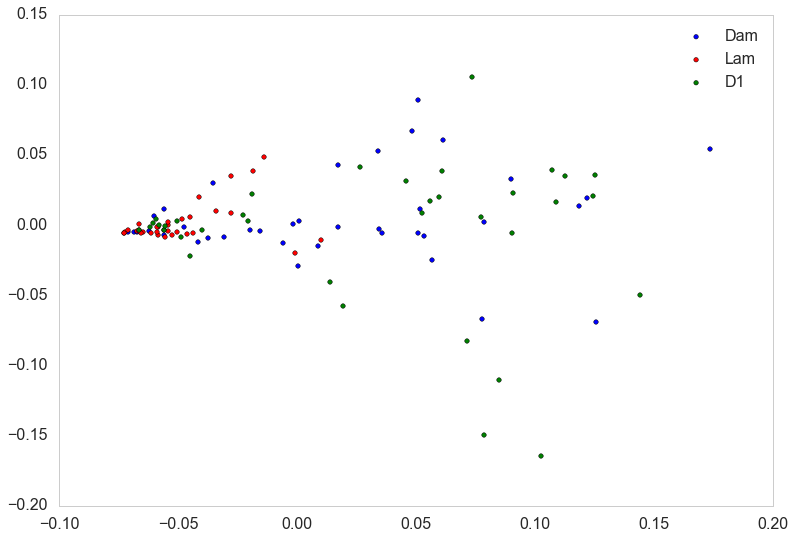

In [309]:
pca = PCA(n_components=10)
X = pca.fit_transform(LoadedData2.transpose())
print pca.explained_variance_ratio_.sum(), "percentage var explained"
print pca.explained_variance_ratio_*100, "explained by first PCs"

df=pd.DataFrame()
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]

colors = ["blue", "red", "green"]
labels= ["Dam","Lam", "D1"]

for label, color in zip(labels, colors):
    mask = [file_names_NoA.loc[name].protein==label for name in LoadedData2.columns]
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()
plt.grid(False)
plt.show()


We divide our datasets into Lam, dam, and D1. This involves first separating dataset

In [252]:
DamMask = [file_names_NoA.loc[name].protein=="Dam" for name in LoadedData2.columns]
LamMask = [file_names_NoA.loc[name].protein=="Lam" for name in LoadedData2.columns]
D1Mask = [file_names_NoA.loc[name].protein=="D1" for name in LoadedData2.columns]

In [257]:
Lam=LoadedData2.ix[:,LamMask]
Dam=LoadedData2.ix[:,DamMask]
D1=LoadedData2.ix[:,D1Mask]

In [310]:
def plot_PCA(Lam):
    pca = PCA(n_components=10)
    X = pca.fit_transform(Lam.transpose())
    print pca.explained_variance_ratio_.sum(), "percentage var explained"
    print pca.explained_variance_ratio_*100, "explained by first PCs"
    
    df=pd.DataFrame()
    for i in range(pca.explained_variance_ratio_.shape[0]):
        df["pc%i" % (i+1)] = X[:,i]
        
    colors = ["blue", "red", "green"]
    labels= ["T","C", "w"]

    for label, color in zip(labels, colors):
        mask = [file_names_NoA.loc[name].Tissue==label for name in Lam.columns]
        plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
    plt.legend()
    plt.grid(False)
    plt.show()

    colors = ["blue", "red", "yellow", 'green']
    labels= ["188","238","257", "89"]

    for label, color in zip(labels, colors):
        mask = [file_names_NoA.loc[name].Line==label for name in Lam.columns]
        plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
    plt.legend()
    plt.grid(False)
    plt.show()


0.997087033225 percentage var explained
[ 64.94918547  24.03249483   5.77720768   2.59086689   1.60019235
   0.26561799   0.18441715   0.16249774   0.07945342   0.0667698 ] explained by first PCs


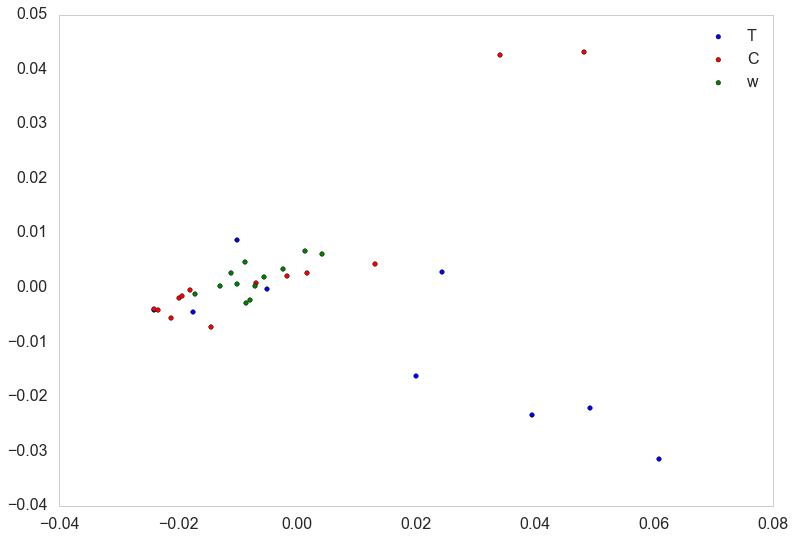

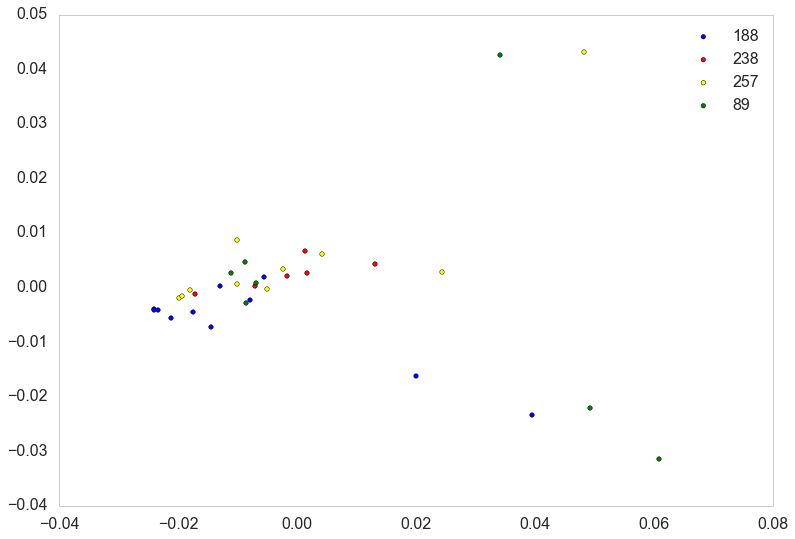

In [311]:
plot_PCA(Lam)

0.998113978739 percentage var explained
[ 65.1785148   17.58243827   9.20335807   4.23231109   1.53626808
   0.93891685   0.45964749   0.40292959   0.18873311   0.08828053] explained by first PCs


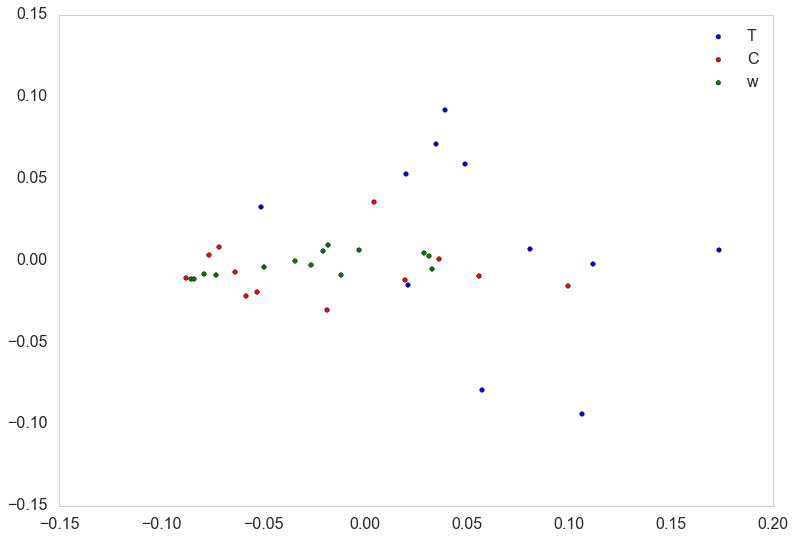

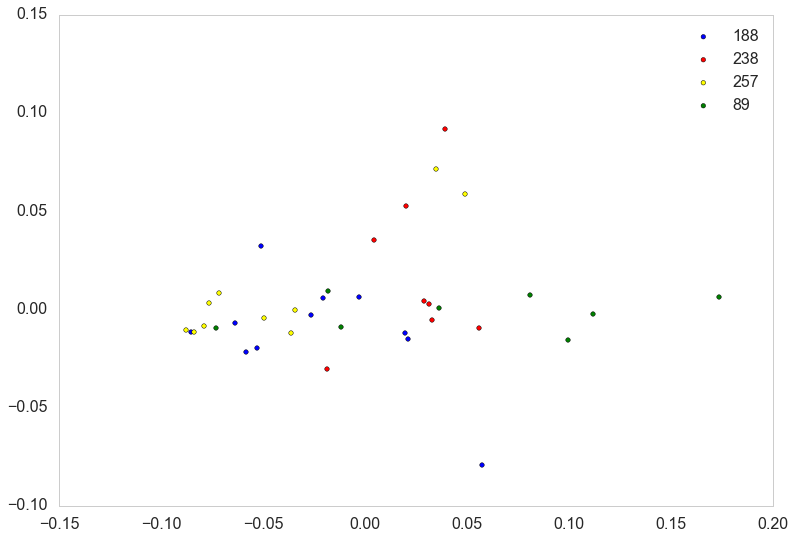

In [312]:
plot_PCA(Dam)

0.991070429104 percentage var explained
[ 51.40810695  30.11245707  11.74974569   2.9498066    0.8859076
   0.77866799   0.45691397   0.40853458   0.18324329   0.17365916] explained by first PCs


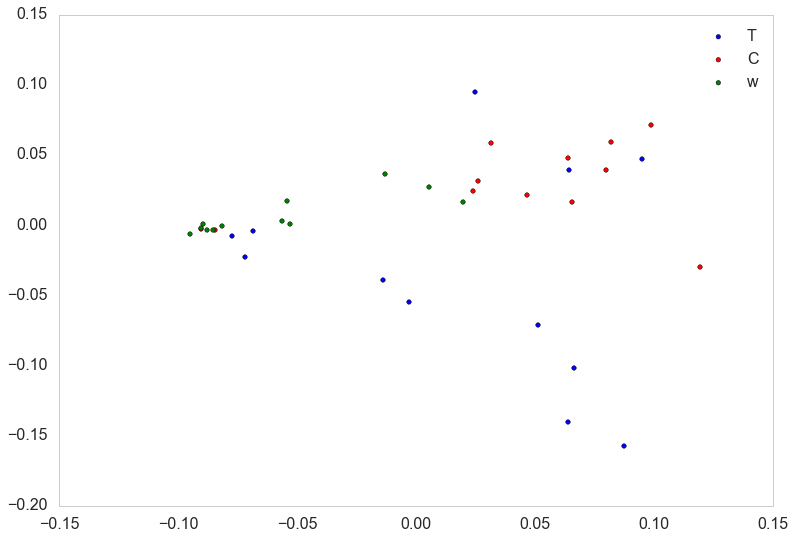

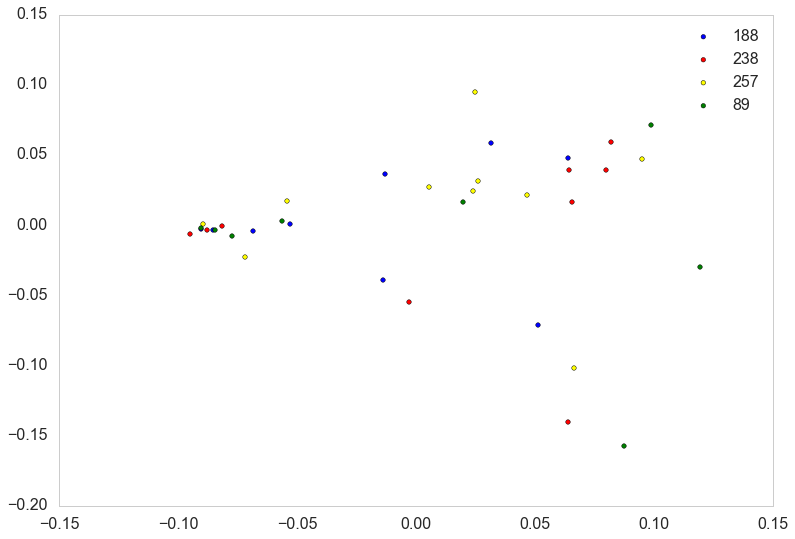

In [313]:
plot_PCA(D1)

In [158]:
print max(pca.components_[0])
print np.argmax(pca.components_[0])
    

0.434384312489
388485
